# Data 4 | KNN

1. Generate a dictionary that takes a neighborhood index and returns a list of the proximate neighborhoods.
2. Then run KNN in parallel over this dictionary. 


## Low Key To Do
1. Maybe do everything with the export date instead of year?
2. Use idu as the index?

In [1]:
from data4_knn import *

T0 = time.time()
data_name = f'{state} | {meters}m'
print_log[data_name] = {'log':[]}
printer(print_log)

files = [file for file in os.listdir(path_3) if 'SNd_' in file and 'm.pkl' in file]
for file in sorted(files):
    pre, year, post = file.split('_')
    data_name = f'{year} @ {k_max}k'
    save_name = f'{year}_{k_max}k.pkl'
    print_log[data_name] = {'log':[],'sublog':[]}
    printer(print_log)
    
    chunk_nums = [x.strip(year) for x in os.listdir(path_1) if year in x]
    future_files = [f'knn_{year}_{k_max}k{chunk}' for chunk in chunk_nums]
    all_files_finished = all([file in os.listdir(path_4 + 'chunks') for file in future_files])

    if all_files_finished:
        print_log[data_name]['log'].append('  Done')
        printer(print_log)
        
    else:
        """ Step 1 | Proximity Matrix """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 1 | Proximity Matrix')
        printer(print_log)
        
        with open(path_3 + file,'rb') as f: 
            SNd = pickle.load(f)
        Pd, POPd = proximity_matrix(SNd, year, print_log)
        runtime = round(( time.time() - t0 ) / 60 )
        print_log[data_name]['log'][-1] = f'  Step 1 | Proximity Matrix (Runtime: {runtime} mins)'

        """ Step 2 | Run KNN by Neighborhood """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 2 | Run KNN by Neighborhood')
        printer(print_log)

        def ni_knn(ni):
            """ Run find the statistics of the nearest k neighbors. """

            n, P, radius = SNd[ni], Pd[ni]['P'], Pd[ni]['radius']
            ni_voters = [SNd[p] for p in P if POPd[p]>0] + [n]
            ni_voters = pd.concat(ni_voters, ignore_index=True)

            n_lat_lon = list(zip(n.lat, n.lon))
            ni_v_lat_lon = list(zip(ni_voters.lat, ni_voters.lon))
            ni_distances = pd.DataFrame(haversine_vector(ni_v_lat_lon, n_lat_lon, Unit.METERS, comb=True))
            ni_distances.columns = ni_voters.idu.values
            ni_distances.index = n.idu.values

            def vi_knn(n, ni_voters, ni_distances):
                """ Run knn for all voters in n. """

                knn_stats = pd.DataFrame(columns=knn_col_names())
                dist_dict = {}
                for vi,v in n.iterrows():
                    try: # This is to handle the rare case when there are multiple voters 
                        v_sorted = ni_distances.loc[v.idu].sort_values()
                    except:
                        v_sorted = ni_distances.loc[v.idu].iloc[0].sort_values()
                    v_0_index = v_sorted[v_sorted == 0].index
                    v_0 = ni_voters[ni_voters.idu.isin(v_0_index)]
                    v_stats = [sum(v_0[p]) for p in party_list]

                    for k in k_list:
                        v_knn_index = v_sorted[:k].index
                        dist_dict[k] = v_knn_index
                        v_knn = ni_voters[ni_voters.idu.isin(v_knn_index)]
                        v_stats += [sum(v_knn[p]) for p in party_list]

                        # could do this with race, and ask whether party or race explains the relationship better ... 
                        # include the turnout of the KNN too ... 
                        # both these changes shoudn't be costly

                        v_kn_index = v_sorted[k-1:k].index[0]
                        v_kn = ni_voters[ni_voters.idu == v_kn_index]
                        v_stats += [v_kn.lat, v_kn.lon, v_sorted[k-1]]
                    knn_stats.loc[v.idu] = [v.idu] + v_stats
                return knn_stats, dist_dict

            return vi_knn(n, ni_voters, ni_distances)

        KNNd, Dd, finished = {}, {}, []
        for ni in SNd:
            KNNd[ni], Dd[ni] = ni_knn(ni)
            finished.append(ni)

            runtime = f'{round( len(finished)*100/len(SNd), 2)}% in {round(( time.time() - t0 ) / 60 )} mins'
            print_log[data_name]['sublog'] = [f'   || KNN {runtime}']
            printer(print_log)
        del SNd

        print_log[data_name]['sublog'] = []
        runtime = round(( time.time() - t0 ) / 60 )
        print_log[data_name]['log'][-1] = f'  Step 2 | Run KNN by Neighborhood (Runtime: {runtime} mins)'
        printer(print_log)

        """ Step 3 | Saving """
        t0 = time.time()
        print_log[data_name]['log'].append('  Step 3 | Saving')
        printer(print_log)
        
        voters = pd.concat(KNNd)
        
        chunk_files = [chunk for chunk in os.listdir(path_1) if year in chunk]
        for chunk_file in chunk_files:
            print(chunk_file)
            chunk_number = chunk_file.strip('NC' + year)
            chunk_save_name = f'{year}_{k_max}k{chunk_number}'

            chunk = pd.read_pickle(path_1 + chunk_file)
            #knn_chunk = {key:KNNd[item] for key in KNNd if key in chunk.idu}
            knn_chunk = voters.merge(chunk)

            #with open(path_4 + f'chunks/KNNd_{chunk_save_name}','wb') as f:
            #    pickle.dump(knn_chunk, f)

            #knn_chunk = pd.concat(knn_chunk, ignore_index=True)
            knn_chunk.to_pickle(path_4 + f'chunks/knn_{chunk_save_name}')
        
        """ Saving print_log """
        now = datetime.now()
        savedate = ''.join([str(now.year),str(now.strftime('%m')),str(now.strftime('%d'))])
        file = open(f'{path_4}print_log_{savedate}.txt', 'w')
        file.write(string_printer(print_log))
        file.close()

NC | 2000m
2010 @ 2050k
  Done
2011 @ 2050k
  Done
2012 @ 2050k
  Done
2013 @ 2050k
  Done
2015 @ 2050k
  Done
2016 @ 2050k
  Done
2017 @ 2050k
  Done
2018 @ 2050k
  Done
2019 @ 2050k
  Step 1 | Proximity Matrix (Runtime: 0 mins)
  Step 2 | Run KNN by Neighborhood (Runtime: 149 mins)
  Step 3 | Saving
2020 @ 2050k
  Step 1 | Proximity Matrix (Runtime: 0 mins)
  Step 2 | Run KNN by Neighborhood (Runtime: 152 mins)
  Step 3 | Saving
2021 @ 2050k
  Step 1 | Proximity Matrix (Runtime: 168 mins)
  Step 2 | Run KNN by Neighborhood (Runtime: 145 mins)
  Step 3 | Saving
2021_chunk_14.pkl
2021_chunk_11.pkl
2021_chunk_2.pkl
2021_chunk_0.pkl
2021_chunk_12.pkl
2021_chunk_4.pkl
2021_chunk_13.pkl
2021_chunk_6.pkl
2021_chunk_15.pkl
2021_chunk_3.pkl
2021_chunk_10.pkl
2021_chunk_9.pkl
2021_chunk_7.pkl
2021_chunk_8.pkl
2021_chunk_1.pkl
2021_chunk_5.pkl


Next thing to do is link to turnout and rerun the main result of the paper using all the data!

Then I want to run using the most recent years.

## Analysis

1. Visualize that the code is correctly selecting a voter's knn.
2. Summarize the data

In [7]:
from data4_knn import *


In [2]:
from ipyleaflet import *

In [8]:
m = Map(center=(52,8), zoom=8, basemap=basemaps.Esri.DeLorme)
m

Map(center=[52, 8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [8]:
def distance(x,y): 
    """Measure the distance between two lat lon combinations in meters"""
    R = 6371000 # meters
    lat1 = math.radians(x[0])
    lat2 = math.radians(y[0])
    latdif = math.radians(y[0]-x[0])
    londif = math.radians(y[1]-x[1])
    a = math.sin(latdif/2) * math.sin(latdif/2) + math.cos(lat1) * math.cos(lat2) * math.sin(londif/2) * math.sin(londif/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R*c

In [77]:
year,state,meters,printLog = 2019,'NC',2000,{}
data = pd.read_csv('data3_neighborhoods/'+state+'/voters_'+str(year)+'_'+str(meters)+'m.csv', low_memory=False)
data['geometry'] = data['geometry'].apply(wkt.loads)

In [207]:
with open('data3_neighborhoods/'+state+'/SNd_'+str(year)+'_'+str(meters)+'m.pkl','rb') as f: SNd = pickle.load(f)
with open('data3_neighborhoods/'+state+'/Ad_'+str(meters)+'m.pkl','rb') as f: Ad = pickle.load(f)

In [149]:
nc_state_squares = gpd.GeoDataFrame()
R_sum, D_sum, O_sum, F0, N, SNI, geometry = [],[],[],[],[],[],[]
sn_I = [i for i in SNd]
for i in sn_I:
    sn_i = SNd[i]
    if sum(list(sn_i['PARTY'] == 'D'))+sum(list(sn_i['PARTY'] == 'R')) > 0:
        R_sum.append(sum(list(sn_i['PARTY'] == 'R'))/len(sn_i))
        D_sum.append(sum(list(sn_i['PARTY'] == 'D'))/len(sn_i))
        O_sum.append(sum(list(sn_i['PARTY'] == 'U'))/len(sn_i))
        F0.append(sum(list(sn_i['PARTY'] == 'R'))/(sum(list(sn_i['PARTY'] == 'D'))+sum(list(sn_i['PARTY'] == 'R'))))
        N.append(len(sn_i))
        SNI.append(i)
        geometry.append(sn_i.iloc[0].geometry)
nc_state_squares['R_sum'] = R_sum
nc_state_squares['D_sum'] = D_sum
nc_state_squares['O_sum'] = O_sum
nc_state_squares['F0'] = F0
nc_state_squares['sn_i'] = SNI
nc_state_squares['N'] = N
nc_state_squares['geometry'] = geometry

In [153]:
charlotte = nc_counties[nc_counties['NAME'] == 'Mecklenburg']
charlotte_squares_i = gpd.overlay(charlotte, nc_state_squares, how='identity', keep_geom_type=None, make_valid=True)
charlotte_squares_i = list(charlotte_squares.sn_i)
charlotte_squares = nc_state_squares[nc_state_squares.sn_i.isin(charlotte_squares_i)]

<ipython-input-153-a2199b91f8e9>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  charlotte_squares_i = gpd.overlay(charlotte, nc_state_squares, how='identity', keep_geom_type=None, make_valid=True)


In [154]:
charlotte_squares = nc_state_squares[nc_state_squares.sn_i.isin(charlotte_squares_i)]

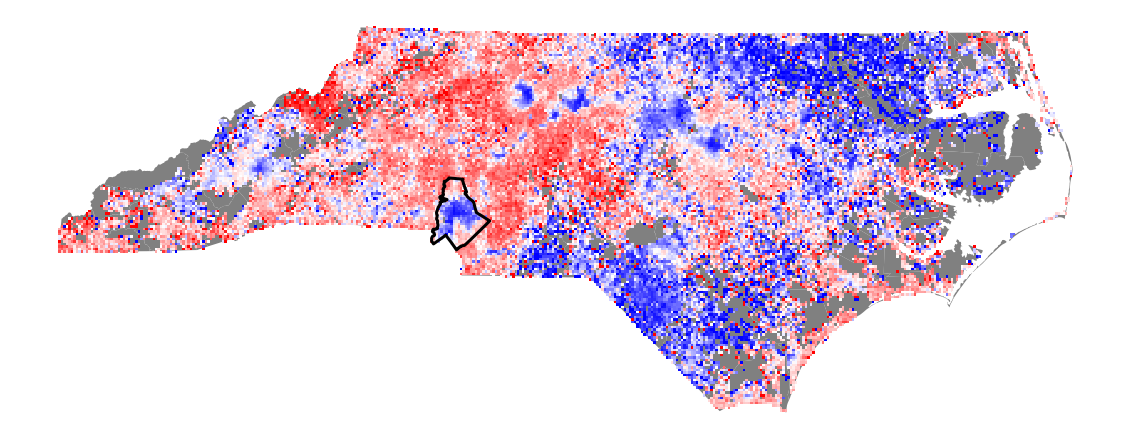

In [139]:
fig, ax = plt.subplots(figsize=(20,20))
nc_counties.plot(ax=ax, color='grey')
nc_state_squares.plot(ax=ax, column='F0', vmin=0, vmax=1, cmap='bwr')
charlotte.plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')
charlotte_squares.plot(ax=ax, column='F0', vmin=0, vmax=1, cmap='bwr')

ax.set_axis_off()

In [240]:
i = 35333

s = charlotte_squares[charlotte_squares.sn_i == i]
a = Ad[i]+[i]
a_sqauares = charlotte_squares[charlotte_squares.sn_i.isin(a)]

Vi = gpd.GeoDataFrame(SNd[i])
Vi['point'] = gpd.points_from_xy(Vi.lon,Vi.lat)
V = pd.concat([SNd[x] for x in a])
V = gpd.GeoDataFrame(V)
V['point'] = gpd.points_from_xy(V.lon,V.lat)
D_points = V[V.PARTY == 'D']
R_points = V[V.PARTY == 'R']

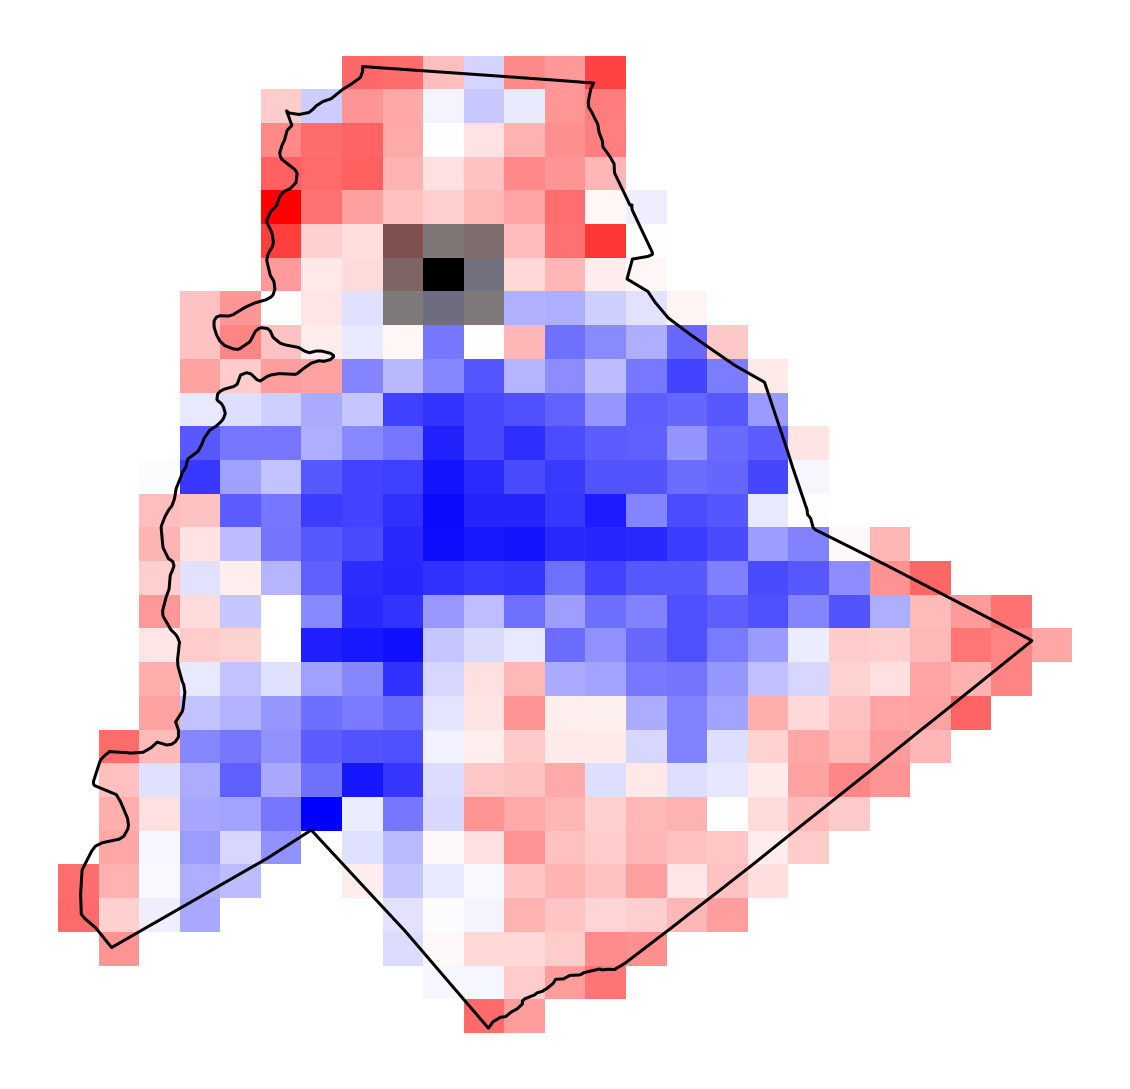

In [312]:
fig, ax = plt.subplots(figsize=(20,20))
charlotte_squares.plot(ax=ax, column='F0', vmin=0, vmax=1, cmap='bwr')
charlotte.plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

s.plot(ax=ax, column='F0', vmin=0, vmax=1, color='black')
a_sqauares.plot(ax=ax, column='F0', vmin=0, vmax=1, color='black',alpha=0.5)

ax.set_axis_off()

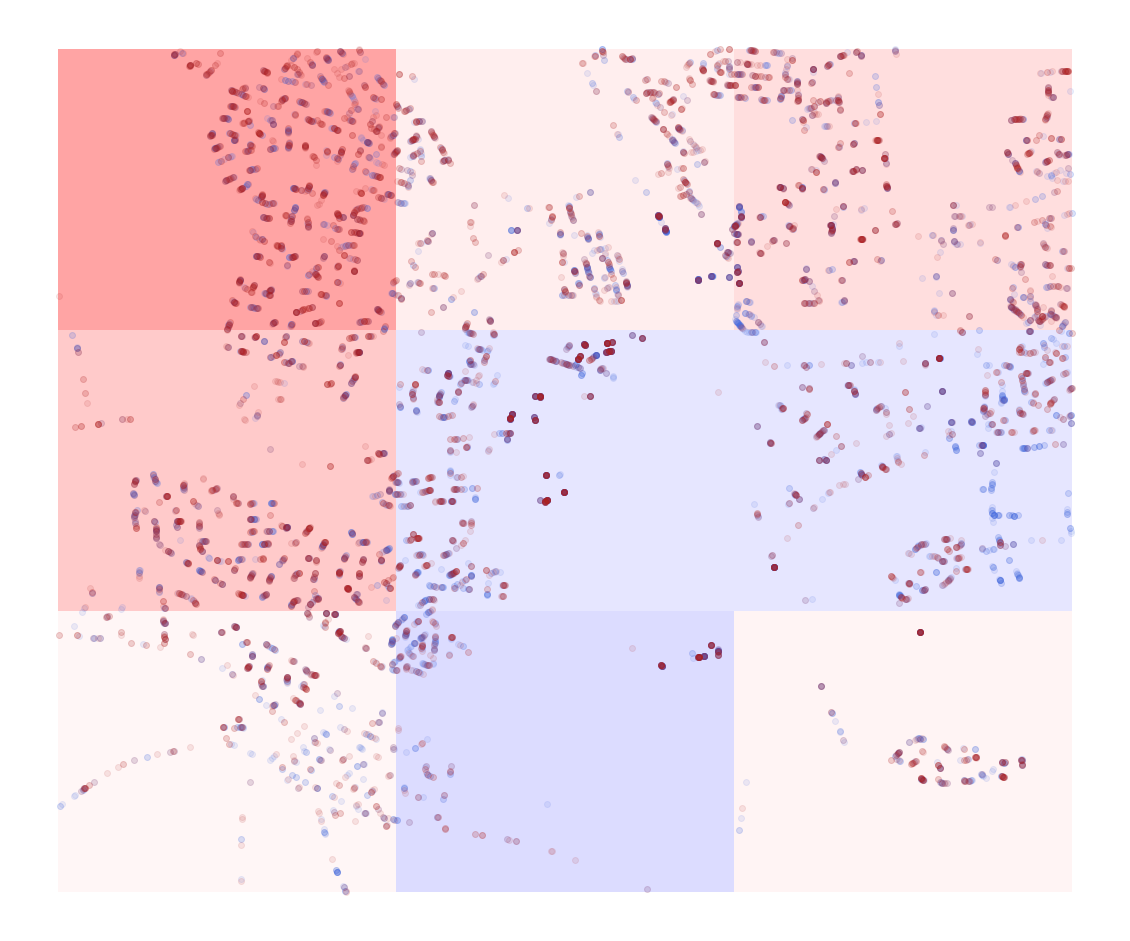

In [313]:
fig, ax = plt.subplots(figsize=(20,20))

a_sqauares.plot(ax=ax, column='F0', vmin=0, vmax=1, cmap='bwr')

#V.point.plot(ax=ax, color='black')
D_points.point.plot(ax=ax, color='royalblue', alpha=0.1)
R_points.point.plot(ax=ax, color='firebrick', alpha=0.1)

ax.set_axis_off()

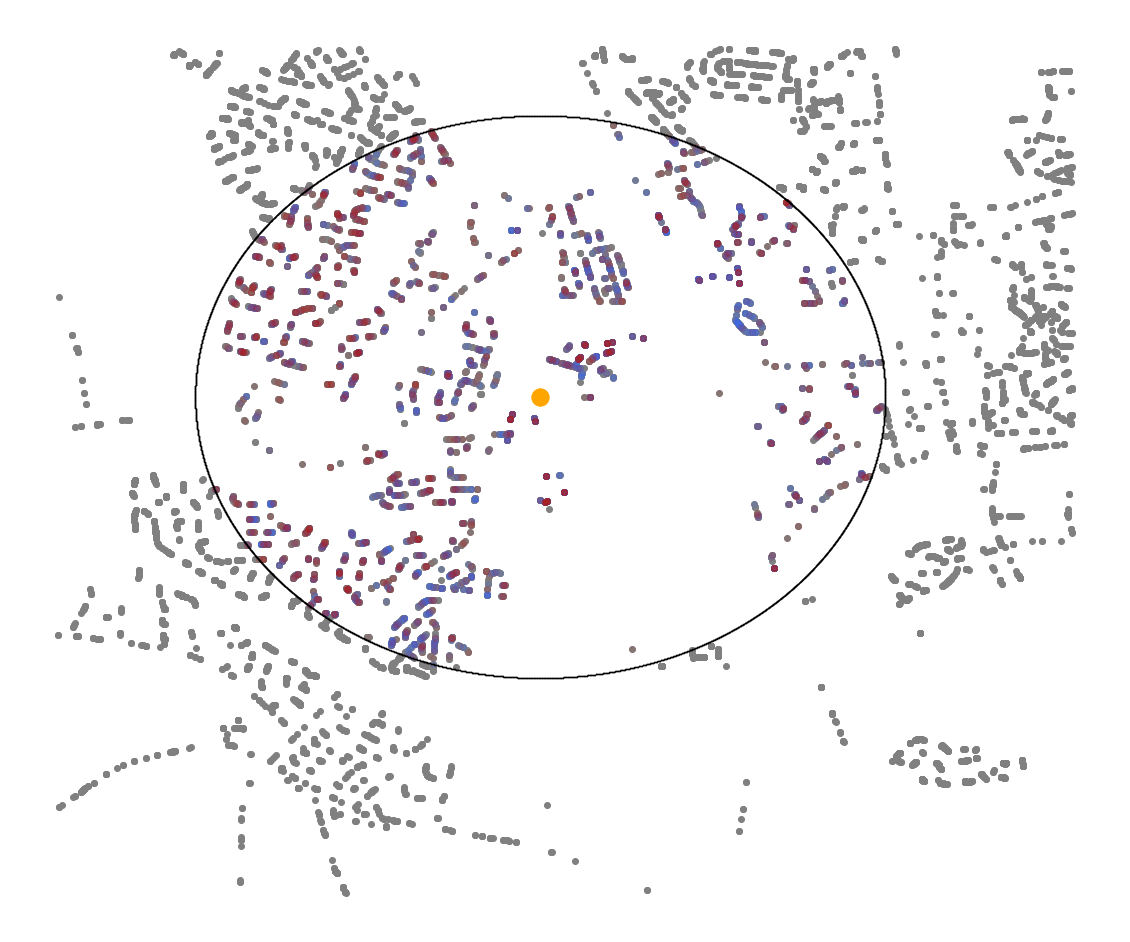

In [322]:
fig, ax = plt.subplots(figsize=(20,20))

#D_points.point.plot(ax=ax, color='royalblue', alpha=0.1)
#R_points.point.plot(ax=ax, color='firebrick', alpha=0.1)
V.point.plot(ax=ax, color='grey')

vi = Vi.iloc[0:1]

radius = 2000
z = []
circle = []

x = [Vi.lat.iloc[0],Vi.lon.iloc[0]]
y = [Vi.lat.iloc[0],Vi.lon.iloc[0]]
while distance(x,y) < radius:
    y[0] = y[0] + ind
z.append(np.abs(x[0] - y[0]))

x = [Vi.lat.iloc[0],Vi.lon.iloc[0]]
y = [Vi.lat.iloc[0],Vi.lon.iloc[0]]
while distance(x,y) < radius:
    y[1] = y[1] + ind
z.append(np.abs(x[1] - y[1]))

circle = [Point(math.sin(2*np.pi/10000*x)*z[1]+Vi.lon.iloc[0],math.cos(2*np.pi/10000*x)*z[0]+Vi.lat.iloc[0]) for x in range(1,10000)]
circleP = gpd.GeoDataFrame()
circleP['geometry'] = circle

vix = Vi.iloc[0]
x = [vix.lat,vix.lon]
Va = []
D = []
for v in range(len(V)):
    y = [V.iloc[v].lat,V.iloc[v].lon]
    D.append(distance(x,y))
    if distance(x,y) < radius:
        Va.append(v)

knn = V.iloc[Va]
knn['point'] = gpd.points_from_xy(knn.lon,knn.lat)
knn[knn.PARTY == 'D'].point.plot(ax=ax,color='royalblue',alpha=0.2)
knn[knn.PARTY == 'R'].point.plot(ax=ax,color='firebrick',alpha=0.1)
#knn[knn.PARTY == 'U'].point.plot(ax=ax,color='grey',alpha=0.1)

vi.point.plot(ax=ax, color='orange', markersize=300)

circleP.plot(ax=ax, color='black', markersize=0.1)

ax.set_axis_off()

In [ ]:
county_map.plot(ax=ax, color='black', alpha=0.6)
neighborhood_map.plot(ax=ax, color='green', alpha=0.3)

In [122]:
counties = gpd.read_file('data0_raw/shapefiles/census_counties_2017/cb_2017_us_county_500k.shp')

<AxesSubplot:>

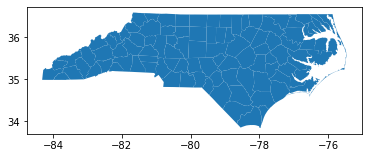

In [127]:
nc_counties = counties[counties['STATEFP'] == '37']
nc_counties.plot()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
175,37,119,01008570,0500000US37119,37119,Mecklenburg,06,1356030322,56685361,"POLYGON ((-81.05803 35.07319, -81.05724 35.086..."


In [23]:
with open('data4_knn/'+state+'/move_switch_knn_'+str(year)+'m.pkl','rb') as f: move_switch = pickle.load(f)

In [40]:
sn_i = 50941
n = move_switch[sn_i]['n']
ni_V = move_switch[sn_i]['ni_V']
ni_D = move_switch[sn_i]['ni_D']
ni_P = move_switch[sn_i]['ni_P']

In [42]:
n.DOUBLE_ID

0    AA1019869052424
Name: DOUBLE_ID, dtype: object

In [38]:
voter['sn_i']

0    427051.0
Name: sn_i, dtype: float64

KeyError: 'rList'

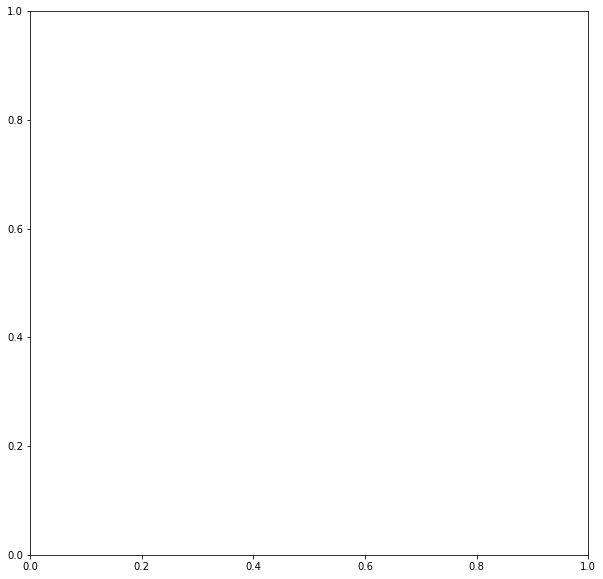

In [21]:
vi = 6000
fig, ax = plt.subplots(figsize=(10,10))
voter = data.iloc[vi:vi+1].reset_index()
voter['point'] = Point(voter.lon,voter.lat)

ind = 0.000001
sni = int(voter.sn_i)
radius = SNd[sni]['rList']['250']*2 # Not sure why, but the radius is doubled...
z = []
circle = []

KeyError: 'rList'

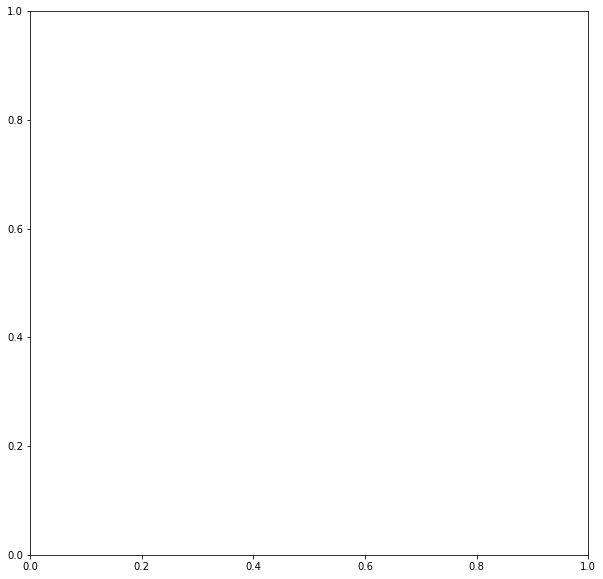

In [9]:


x = [voter.lat[0],voter.lon[0]]
y = [voter.lat[0],voter.lon[0]]
while distance(x,y) < radius:
    y[0] = y[0] + ind
z.append(np.abs(x[0] - y[0]))

x = [voter.lat[0],voter.lon[0]]
y = [voter.lat[0],voter.lon[0]]
while distance(x,y) < radius:
    y[1] = y[1] + ind
z.append(np.abs(x[1] - y[1]))

circle = [Point(math.sin(2*pi/n*x)*z[1]+voter.lon[0],math.cos(2*pi/n*x)*z[0]+voter.lat[0]) for x in range(0,5000)]

circleP = gpd.GeoDataFrame()
circleP['geometry'] = circle
circleP.plot(ax=ax, color='green', markersize=0.1)

pList = SNd[sni]['pList']['250']+[sni]
neighbors = data[data.sn_i.isin(pList)]

neighbors = gpd.GeoDataFrame(neighbors, geometry='geometry')
neighbors.plot(ax=ax, color='purple')

neighbors['point'] = gpd.points_from_xy(neighbors.lon,neighbors.lat)
neighbors = gpd.GeoDataFrame(neighbors, geometry='point')
neighbors.plot(ax=ax, color='blue')

voter = gpd.GeoDataFrame(voter, geometry='point')
voter.plot(ax=ax, color='red')

#dis = []
#for ni in neighbors.index:
#    n = neighbors.loc[ni]
#    dis.append(distance([n.lat,n.lon],[voter.lat,voter.lon]))

ax.set_axis_off()
#plt.savefig('small_sort_i/validation_1.pdf')

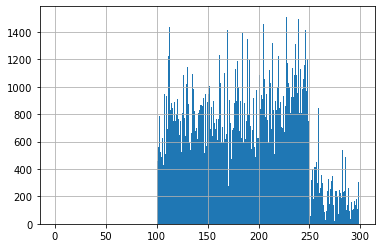

In [17]:
year,state,meters,printLog = 2019,'NC',250,{}
chunk = 29 # 55
data = pd.read_csv('data3_neighborhoods/'+state+'/'+str(year)+'_'+str(meters)+'m_fast/voters_'+str(year)+'_'+str(meters)+'m_chunk'+str(chunk)+'_fast.csv', low_memory=False)

#year,state,meters,printLog = 2005,'NC',100,{}
#data = pd.read_csv('data3_neighborhoods/'+state+'/voters_'+str(year)+'_'+str(meters)+'m_fast.csv', low_memory=False)
#data['geometry'] = data['geometry'].apply(wkt.loads)
#data['POP5'] = data['D5'] + data['R5'] + data['O5']
#data['POP25'] = data['D25'] + data['R25'] + data['O25']
data['POP100'] = data['D100'] + data['R100'] + data['O100']
data['POP250'] = data['D250'] + data['R250'] + data['O250']

data.POP250.hist(bins=np.arange(300))

In [45]:
data[data.radius_250 == data.radius_250.min()]

,Unnamed: 0,ID_NUM,CITY,STATE,ZIP_CODE,ID_NUM_a,GENDER,AGE,BIRTHPLACE,RACE,...,R250,O250,radius_250,D_niStat,R_niStat,O_niStat,POP5,POP25,POP100,POP250
26506,27293,,WILMINGTON,NC,28412.0,207833,F,46.0,NC,WHITE,...,86,56,110.0,36,38,31,105,105,105,210
26507,181790,,WILMINGTON,NC,28412.0,215131,M,27.0,NY,WHITE,...,86,56,110.0,36,38,31,105,105,105,210
26508,213621,,WILMINGTON,NC,28412.0,214942,M,19.0,AL,WHITE,...,86,56,110.0,36,38,31,105,105,105,210
26509,213653,,WILMINGTON,NC,28412.0,214952,F,58.0,MI,WHITE,...,86,56,110.0,36,38,31,105,105,105,210
26510,213675,,WILMINGTON,NC,28412.0,214958,F,50.0,MI,WHITE,...,86,56,110.0,36,38,31,105,105,105,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162214,5747440,,WILMINGTON,NC,28405.0,211092,F,35.0,WV,WHITE,...,78,36,110.0,40,41,24,105,105,105,184
162215,5747460,,WILMINGTON,NC,28405.0,211096,M,36.0,NC,BLACK or AFRICAN AMERICAN,...,78,36,110.0,40,41,24,105,105,105,184
162216,5773657,,WILMINGTON,NC,28405.0,131620,F,81.0,NC,WHITE,...,78,36,110.0,40,41,24,105,105,105,184
162217,5931291,,WILMINGTON,NC,28405.0,193184,F,58.0,FL,BLACK or AFRICAN AMERICAN,...,78,36,110.0,40,41,24,105,105,105,184


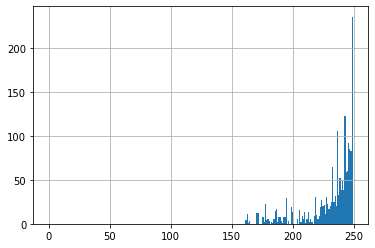

In [14]:
data.POP250.hist(bins=np.arange(250))

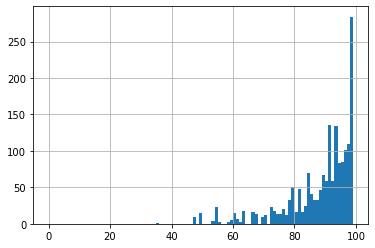

In [13]:
data.POP100.hist(bins=np.arange(100))

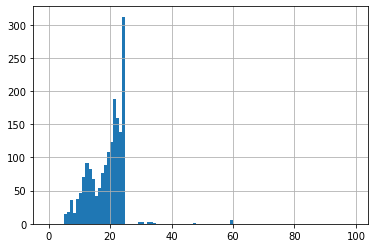

In [15]:
data.POP25.hist(bins=np.arange(100))

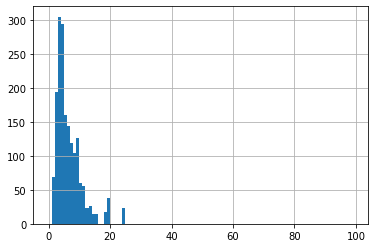

In [16]:
data.POP5.hist(bins=np.arange(100))

### Old

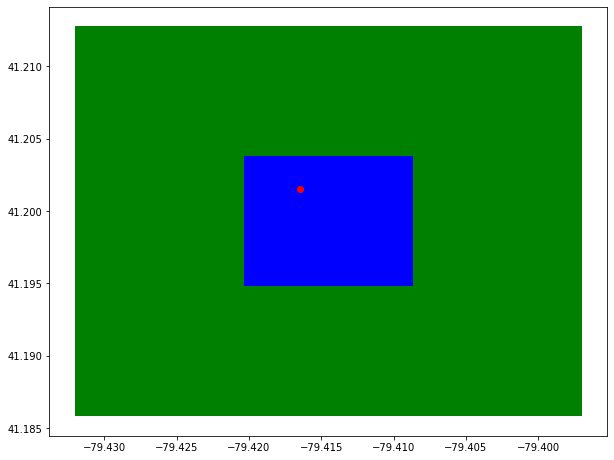

In [86]:
j = 4

x = data.iloc[j:j+1].reset_index()
y = data.iloc[j:j+1].reset_index()
y['geom'] = Point(float(x.lon[0]), float(x.lat[0]))
y = gpd.GeoDataFrame(y, geometry='geom')

z = data.iloc[j:j+1].reset_index()
i = z
z['geom'] = Polygon([(float(i.w_l[0]), float(i.h_l[0])), (float(i.w_u[0]), float(i.h_l[0])), (float(i.w_u[0]), float(i.h_u[0])), (float(i.w_l[0]), float(i.h_u[0]))])
z = gpd.GeoDataFrame(z, geometry='geom')

fig, ax = plt.subplots(figsize=(10,10))
z.plot(ax=ax, color='green')
x.plot(ax=ax, color='blue')
y.plot(ax=ax, color='red')

# Visualization

In [21]:
state = 'PA'
year = 2018
meters = 1000
filepath1 = 'neighbors1/'+state+'/'+state+'_'+str(year)+'/'

In [22]:
def neighborhood_mapping(row):
    w = row[1].w1
    h = row[1].h1
    return Polygon([(w, h), (w+lon_int, h), (w+lon_int, h+lat_int), (w, h+lat_int)])

In [23]:
neighborhood_map = pd.read_csv(filepath1+'squares/neighborhood_stats_'+str(meters)+'m_small.csv')
neighborhood_map.loc[:,'geometry'] = [neighborhood_mapping(row) for row in neighborhood_map.iterrows()]
neighborhood_map = gpd.GeoDataFrame(neighborhood_map)

In [30]:
neighborhood_map.loc[:,'N'] = neighborhood_map['D'] + neighborhood_map['R']
neighborhood_map.loc[:,'D_share'] = neighborhood_map['D']/neighborhood_map['N']
neighborhood_map.loc[:,'R_share'] = neighborhood_map['R']/neighborhood_map['N']

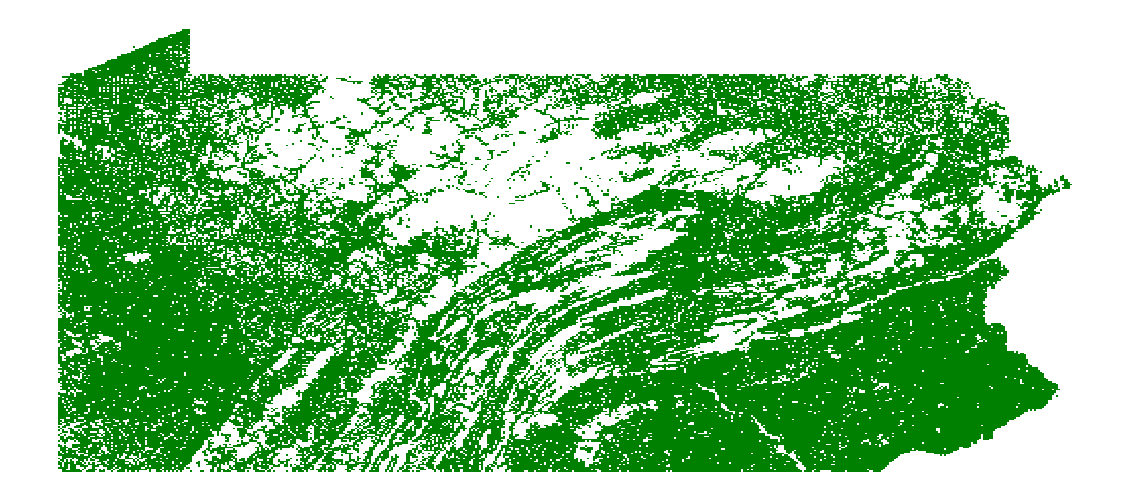

In [351]:
fig, ax = plt.subplots(figsize=(20,20))
neighborhood_map.plot(ax=ax, color='green')
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_0.pdf')
plt.savefig('i_homophily/PA_squares_figure_0.png')

In [35]:
map_crs = {'init':'epsg:3395', 'units':'m'}

In [36]:
us_counties = gpd.read_file('shapefiles0/cb_2017_us_county_500k.shp')
#us_counties = us_counties.to_crs(map_crs)

In [37]:
state_fip = '42'
state_map = us_counties[us_counties['STATEFP'].isin([state_fip])].reset_index()
county_map = state_map[state_map['NAME'] == 'Allegheny']

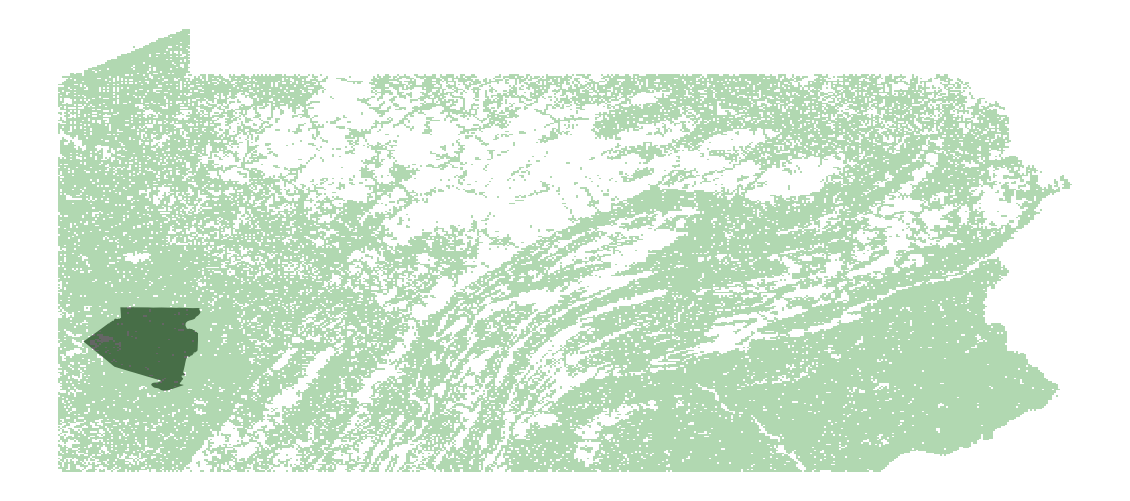

In [352]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='black', alpha=0.6)
neighborhood_map.plot(ax=ax, color='green', alpha=0.3)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_1.pdf')
plt.savefig('i_homophily/PA_squares_figure_1.png')

In [38]:
county_geo = county_map['geometry'].iloc[0]
county_neighbors = neighborhood_map[neighborhood_map.within(county_geo)]

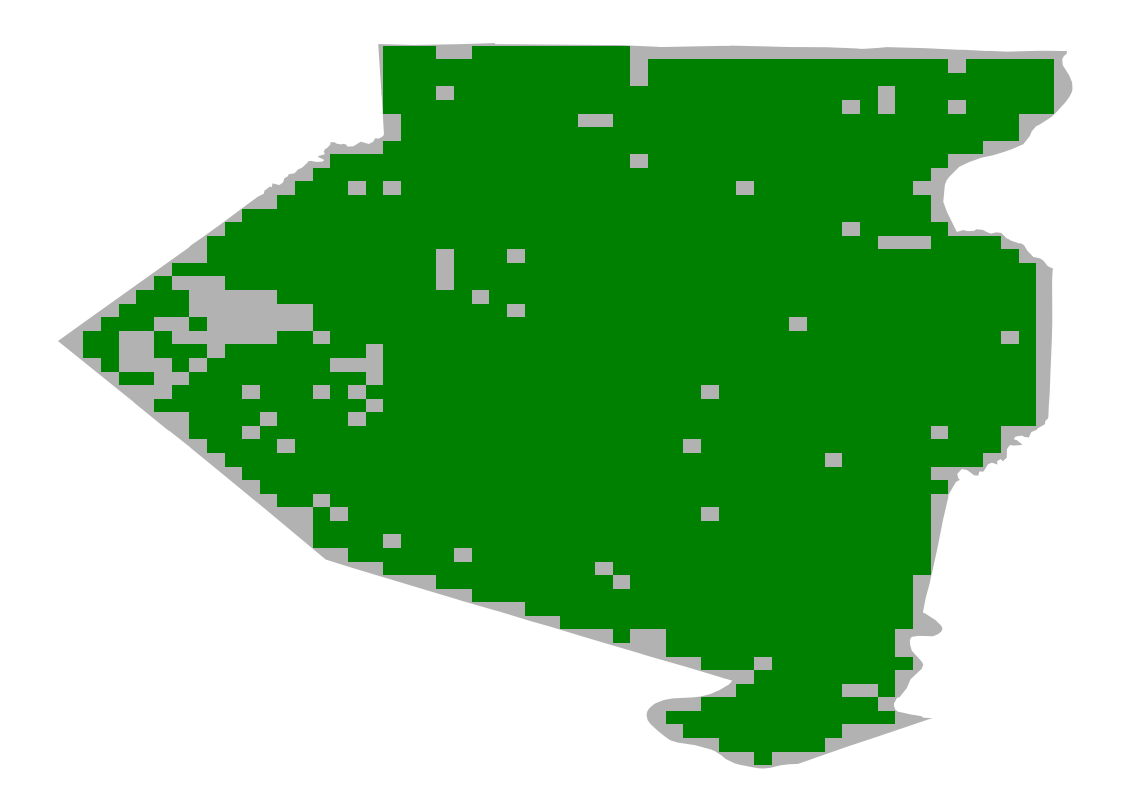

In [353]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='grey', alpha=0.6)
county_neighbors.plot(ax=ax, color='green')
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_2.pdf')
plt.savefig('i_homophily/PA_squares_figure_2.png')

In [56]:
neighbor = county_neighbors.iloc[270:271]

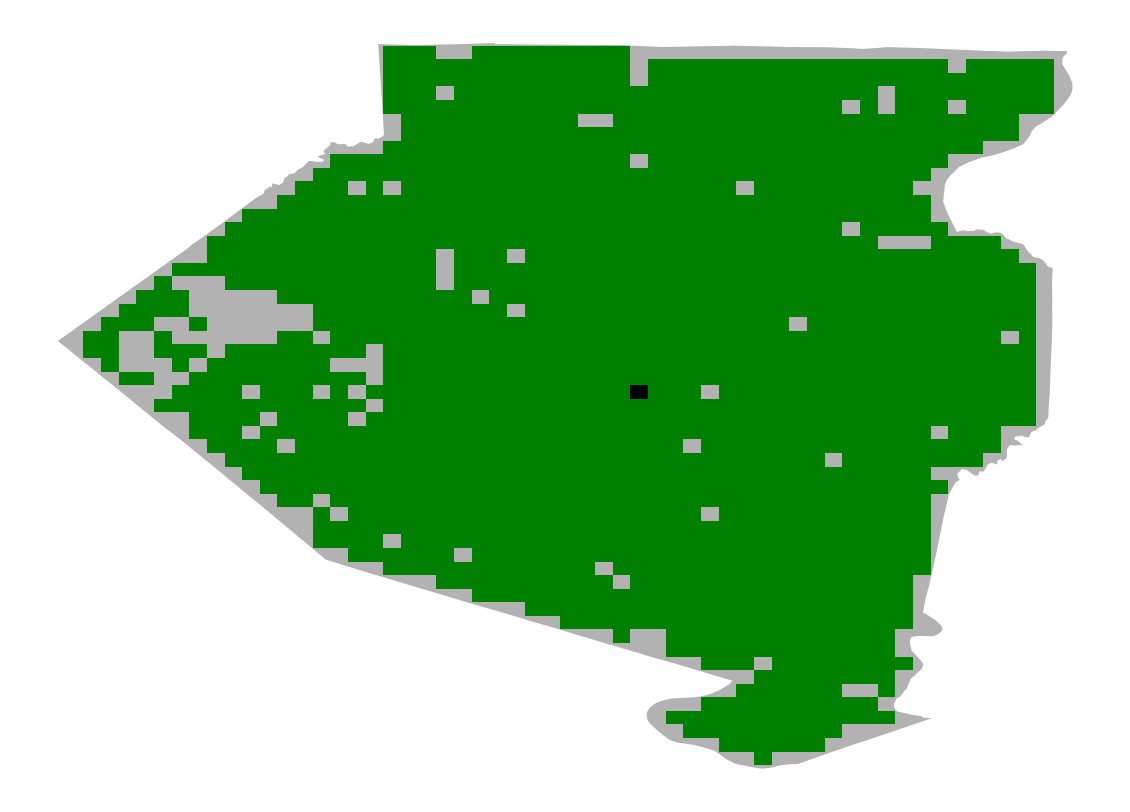

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='grey', alpha=0.6)
county_neighbors.plot(ax=ax, color='green')
neighbor.plot(ax=ax, color='black')
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_3.pdf')
plt.savefig('i_homophily/PA_squares_figure_3.png')

In [58]:
h1_min = neighbor.h1.iloc[0] - lat_int*3.5
h1_max = neighbor.h1.iloc[0] + lat_int*3.5
w1_min = neighbor.w1.iloc[0] - lon_int*3.5
w1_max = neighbor.w1.iloc[0] + lon_int*3.5
county_neighbors_buffer = county_neighbors[(county_neighbors.h1 > h1_min) & 
                                           (county_neighbors.h1 < h1_max) & 
                                           (county_neighbors.w1 > w1_min) &
                                           (county_neighbors.w1 < w1_max) ]

In [59]:
voter_map = pd.read_csv(filepath1+'squares/voter_stats_'+str(meters)+'m_small.csv', low_memory=False)
voter_map = gpd.GeoDataFrame(voter_map, geometry=gpd.points_from_xy(voter_map.lon, voter_map.lat))

In [60]:
h1_min = neighbor.h1.iloc[0] - lat_int*2.5
h1_max = neighbor.h1.iloc[0] + lat_int*4.5
w1_min = neighbor.w1.iloc[0] - lon_int*2.5
w1_max = neighbor.w1.iloc[0] + lon_int*4.5
subsample = voter_map[(voter_map.h1 > h1_min) & 
                      (voter_map.h1 < h1_max) & 
                      (voter_map.w1 > w1_min) &
                      (voter_map.w1 < w1_max)]

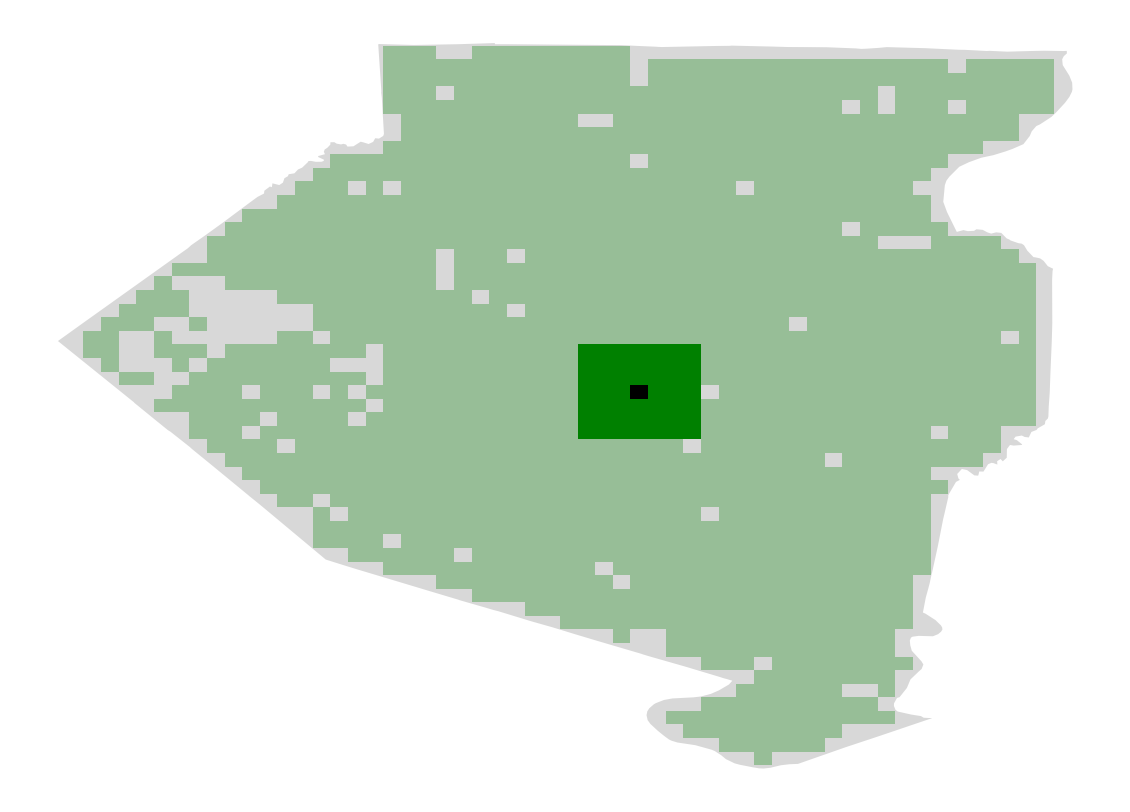

In [61]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='grey', alpha=0.3)
county_neighbors.plot(ax=ax, color='green', alpha=0.3)
county_neighbors_buffer.plot(ax=ax, color='green')
neighbor.plot(ax=ax, color='black')
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_4.pdf')
plt.savefig('i_homophily/PA_squares_figure_4.png')

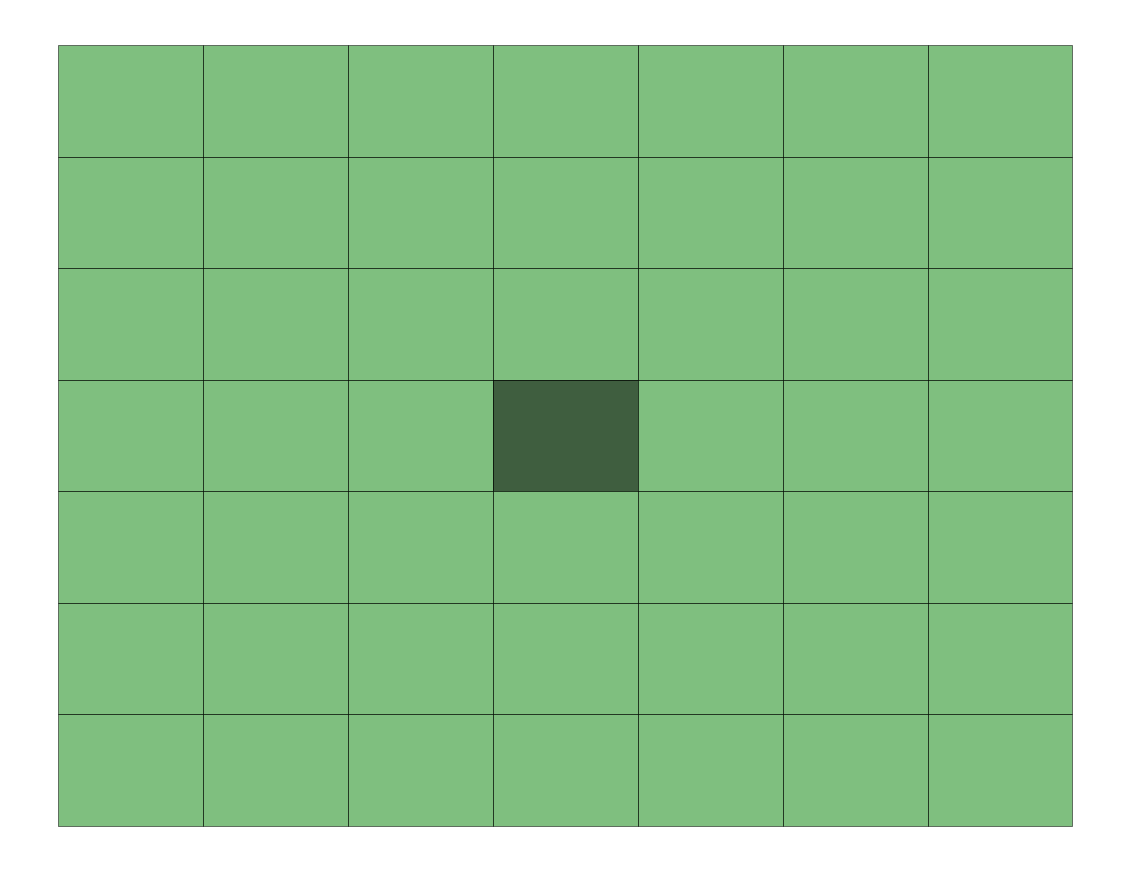

In [62]:
fig, ax = plt.subplots(figsize=(20,20))
county_neighbors_buffer.plot(ax=ax, color='green', alpha=0.5, edgecolor='black')
neighbor.plot(ax=ax, color='black', alpha=0.5)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_5.pdf')
plt.savefig('i_homophily/PA_squares_figure_5.png')

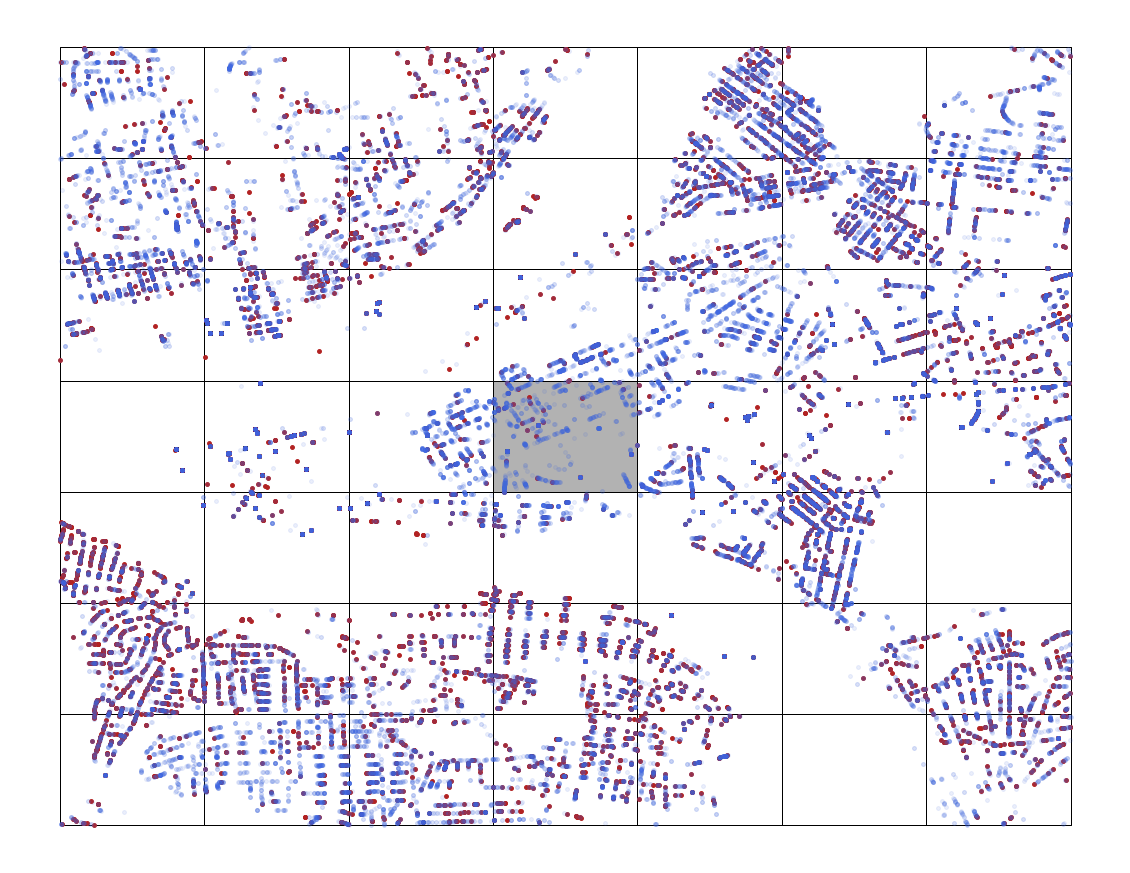

In [63]:
fig, ax = plt.subplots(figsize=(20,20))
county_neighbors_buffer.plot(ax=ax, color='white', edgecolor='black')
neighbor.plot(ax=ax, color='black', alpha=0.3)
rep = subsample[subsample.R == 1]
dem = subsample[subsample.D == 1]
rep.plot(ax=ax, color='firebrick', alpha=1, markersize=15)
dem.plot(ax=ax, color='royalblue', alpha=0.1, markersize=15)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_6.pdf')
plt.savefig('i_homophily/PA_squares_figure_6.png')

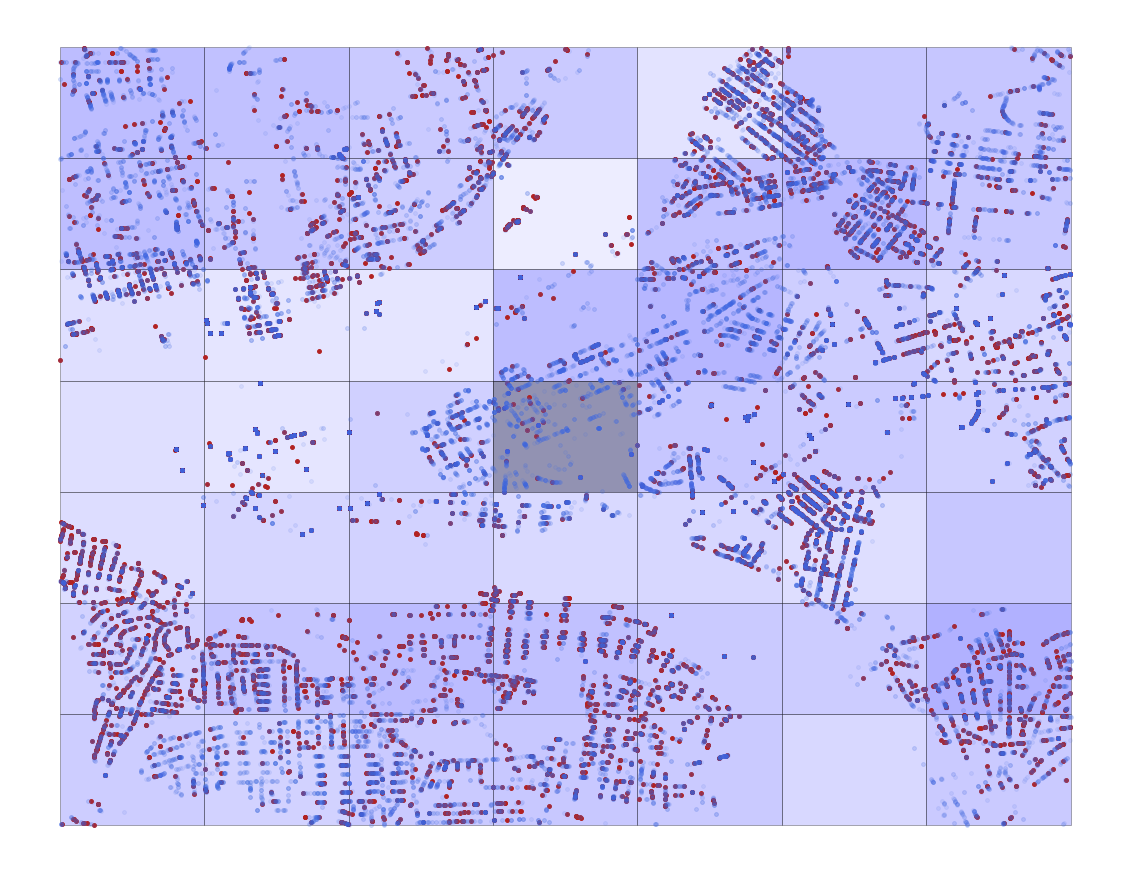

In [67]:
fig, ax = plt.subplots(figsize=(20,20))
#county_neighbors_buffer.plot(ax=ax, color='white', edgecolor='black')
county_neighbors_buffer.plot(ax=ax, edgecolor='black', column='R_share', vmin=0, vmax=1, cmap='bwr', alpha=0.3)

neighbor.plot(ax=ax, color='black', alpha=0.3)
rep = subsample[subsample.R == 1]
dem = subsample[subsample.D == 1]
rep.plot(ax=ax, color='firebrick', alpha=1, markersize=15)
dem.plot(ax=ax, color='royalblue', alpha=0.1, markersize=15)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_7.pdf')
plt.savefig('i_homophily/PA_squares_figure_7.png')

In [135]:
state = 'PA'
year = 2019
filepath2 = 'data2/'+state+'/'+state+'_'+str(year)+'/'
16374 - len([x for x in os.listdir(filepath2) if x.split('_')[-1] != 'in.csv'])

781

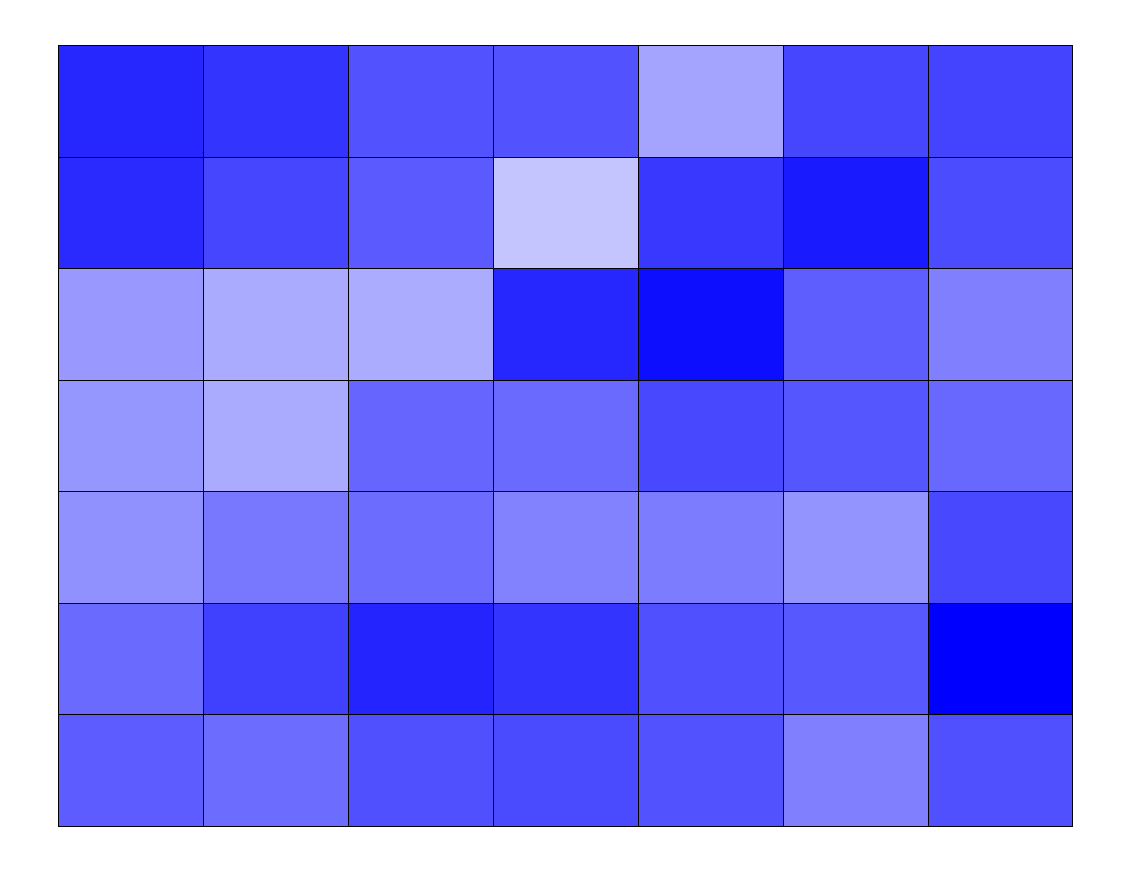

In [71]:
fig, ax = plt.subplots(figsize=(20,20))
county_neighbors_buffer.plot(ax=ax, edgecolor='black', column='R_share', vmin=0, vmax=1, cmap='bwr')

ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_7B.pdf')
plt.savefig('i_homophily/PA_squares_figure_7B.png')

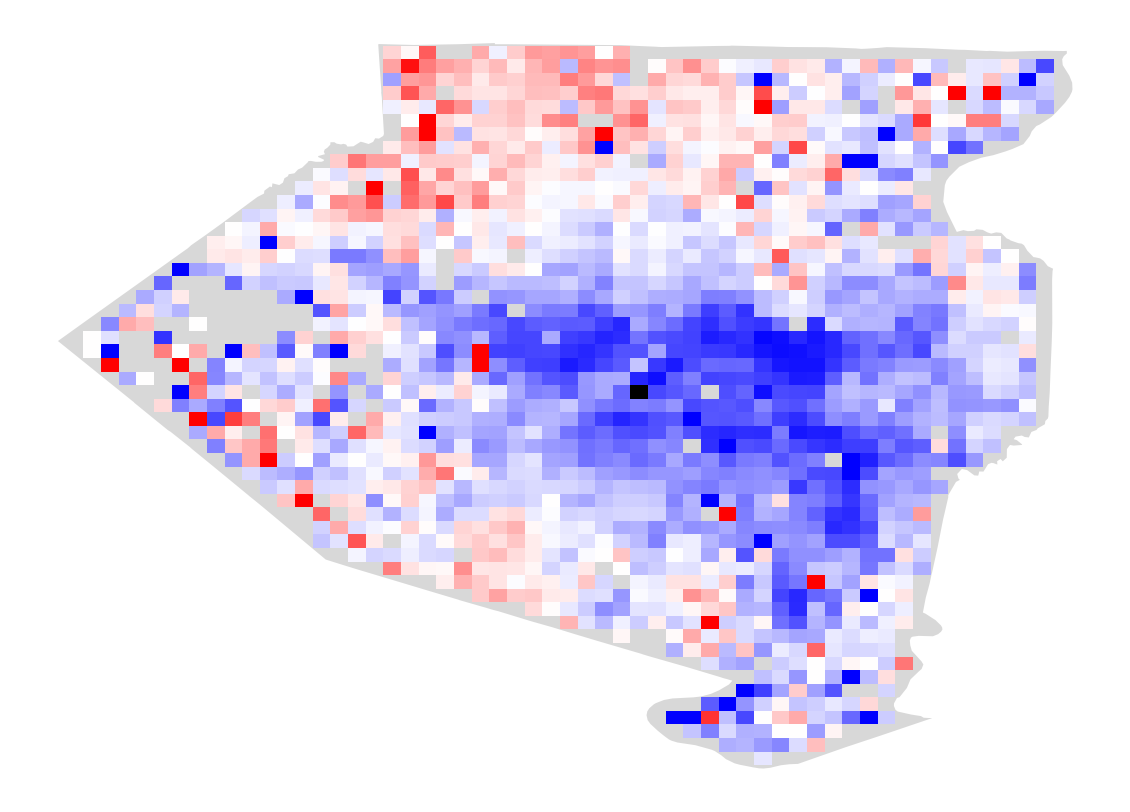

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='grey', alpha=0.3)
county_neighbors.plot(ax=ax, column='R_share', vmin=0, vmax=1, cmap='bwr')
#county_neighbors_buffer.plot(ax=ax, column='R_share', cmap='bwr')
neighbor.plot(ax=ax, color='black')
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_10.pdf')
plt.savefig('i_homophily/PA_squares_figure_10.png')

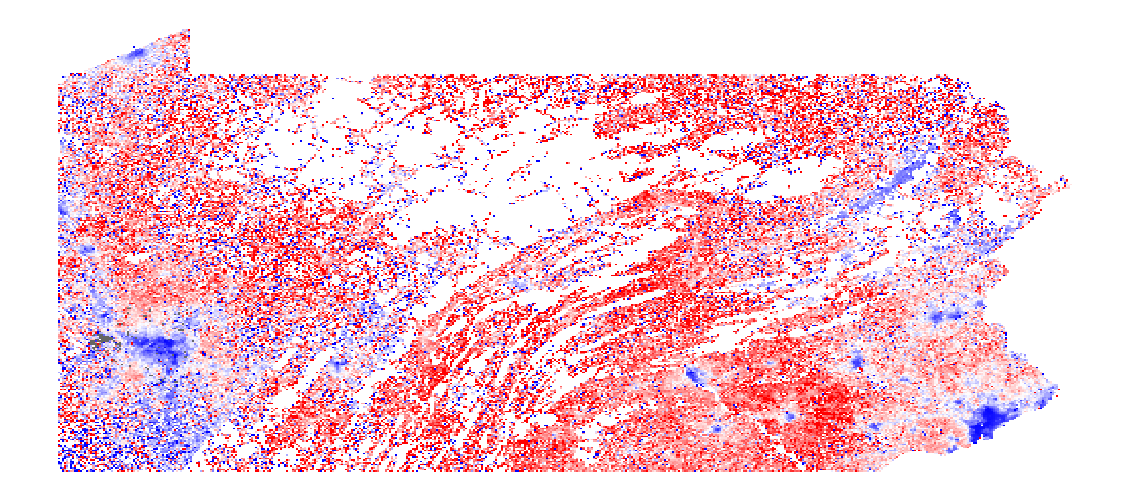

In [73]:
fig, ax = plt.subplots(figsize=(20,20))
county_map.plot(ax=ax, color='black', alpha=0.6)
neighborhood_map.plot(ax=ax, column='R_share', cmap='bwr', vmin=0, vmax=1)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_11.pdf')
plt.savefig('i_homophily/PA_squares_figure_11.png')

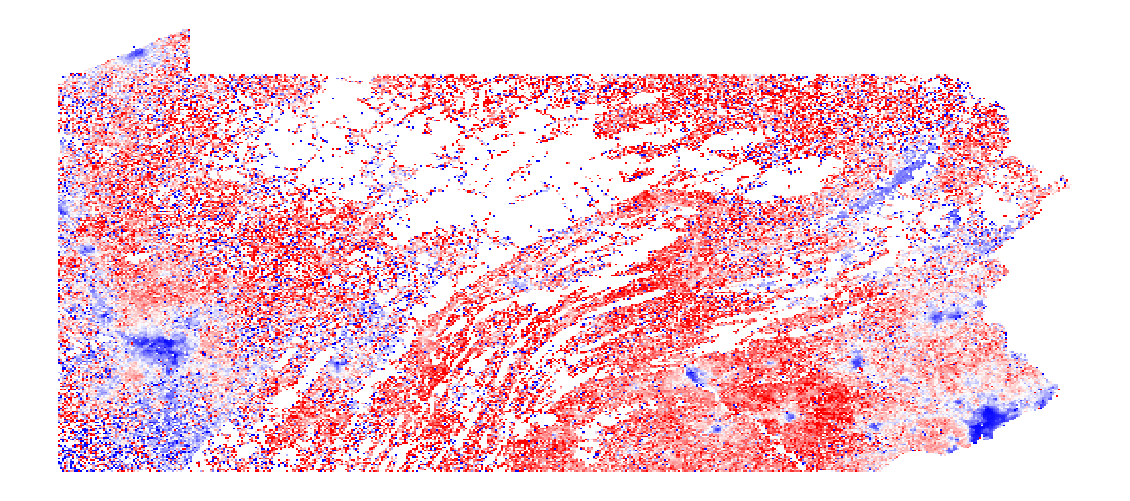

In [72]:
fig, ax = plt.subplots(figsize=(20,20))
neighborhood_map.plot(ax=ax, column='R_share', cmap='bwr', vmin=0, vmax=1)
ax.set_axis_off()
plt.savefig('i_homophily/PA_squares_figure_12.pdf')
plt.savefig('i_homophily/PA_squares_figure_12.png')

## ACS Example Visualization

In [25]:
year = 2018
state = 'PA'
grid_size = 5000 # meters

filepath1 = 'data1/'+state+'/'+state+'_'+str(year)+'/'
filepath4 = 'data4/'+state+'/'+state+'_'+str(year)+'/'+str(grid_size)+'/'

for county_name in ['ADAMS']:    
    print(county_name)
    print('  Grid Size:',grid_size,'m')
    t0 = time.time()
    
    # ACS Statistics

    neighborhoods = gpd.read_file(filepath4+county_name+'/neighborhoods.shp')
    neighborhoods.crs = {'init': 'epsg:3395'}
    neighborhoods = neighborhoods.to_crs({'init' :'epsg:4269'})
    
    # maybe consider changing the projection
    # map_crs = {'init':'epsg:3395', 'units':'m'}
    
    print('  Neighborhoods:',len([x for x in neighborhoods.iterrows()]))
    t0 = time.time()

    X = []
    neighborhood_list = neighborhoods.iterrows()
    
    n = [x for x in neighborhood_list][0]
        
    n_geo = n[1]['geometry']
    zip_intersection = county_file.intersection(n_geo)

    index = gpd.GeoDataFrame([county_file.iloc[i] for i in county_file.index if zip_intersection.iloc[i].area > 0])
    index.loc[:,'intersect_area'] = [i.area for i in zip_intersection if i.area > 0]
    index.loc[:,'area'] = [index.geometry.iloc[i].area for i in range(len(index))]
    index.loc[:,'perc_intersect'] = index['intersect_area']/index['area']
    index.loc[:,'perc_land'] = index['ALAND10']/(index['ALAND10']+index['AWATER10'])

    X_sub = [n[0]]
    for col in pop_cols:
        X_sub.append(sum(index[col]*index['perc_intersect']))
    #for col in inc_cols:
    #    X_sub.append(sum(index[col]*index['perc_intersect']))
    X_sub.append(sum(index['perc_land']*index['perc_intersect']))

ADAMS
  Grid Size: 5000 m
  Neighborhoods: 93


In [26]:
index['Total']

979     11567
1005    29525
1022     5619
1049     3667
Name: Total, dtype: int64

In [27]:
index['perc_intersect']

979     0.174511
1005    0.025144
1022    0.046004
1049    0.044828
Name: perc_intersect, dtype: float64

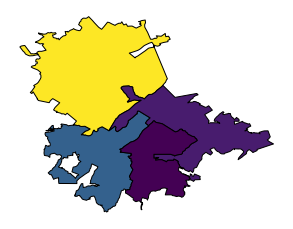

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
#gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='grey', alpha=0.8)
#zip_intersection.plot(ax=ax, color='grey', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_1.pdf')

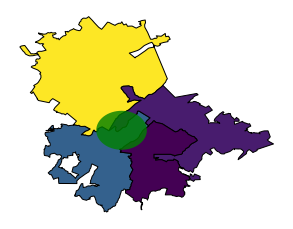

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='green', alpha=0.8)
#zip_intersection.plot(ax=ax, color='grey', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_2.pdf')

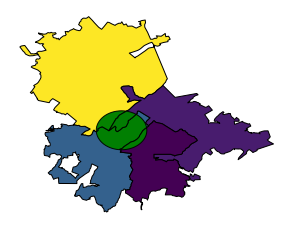

In [37]:
fig, ax = plt.subplots(figsize=(5,5))
index.plot(ax=ax, edgecolor='black',column='Total')
gpd.GeoDataFrame([n[1]]).plot(ax=ax, color='green', alpha=0.8)
zip_intersection.plot(ax=ax, color='green', alpha=0.9, edgecolor='black')
ax.set_axis_off()
plt.savefig('figures/acs_3.pdf')

In [ ]:
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
# https://web.stanford.edu/~jrodden/jrhome_files/electiondata.htm
# https://projects.iq.harvard.edu/eda/data
# https://www.pavoterservices.pa.gov/Pages/PollingPlaceInfo.aspx

In [28]:
block = gpd.read_file('shapefiles0/tl_2019_37_tabblock10/tl_2019_37_tabblock10.shp')
#zipcode['ZCTA'] = ['ZCTA5 '+x for x in zipcode['ZCTA5CE10']]
#zipcode = zipcode.sort_values('ZCTA')
# maybe consider changing the projection
# map_crs = {'init':'epsg:3395', 'units':'m'}

In [29]:
block.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,37,031,970602,1022,370319706021022,Block 1022,G5040,R,None,None,S,0,783785,+34.7226385,-076.8957622,"POLYGON ((-76.901048 34.727175, -76.9005449999..."
1,37,031,970801,2031,370319708012031,Block 2031,G5040,R,None,None,S,130921,0,+34.7305293,-077.0809037,"POLYGON ((-77.082694 34.729998, -77.082672 34...."
2,37,031,970805,1034,370319708051034,Block 1034,G5040,R,None,None,S,172700,0,+34.7263007,-077.0617000,"POLYGON ((-77.063935 34.726251, -77.0630029999..."
3,37,031,970801,2036,370319708012036,Block 2036,G5040,R,None,None,S,42117,0,+34.7179683,-077.0726058,"POLYGON ((-77.073577 34.717416, -77.073149 34...."
4,37,031,970801,2056,370319708012056,Block 2056,G5040,U,59194,C,S,56641,0,+34.7145979,-077.0689843,"POLYGON ((-77.069988 34.715601, -77.0698699999..."


In [11]:
bg = gpd.read_file('shapefiles0/tl_2019_01_bg/tl_2019_01_bg.shp')

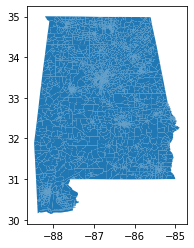

In [16]:
bg.plot()

In [13]:
tabblock = gpd.read_file('data0/acs/tl_2019_11_tabblock10/tl_2019_11_tabblock10.shp')

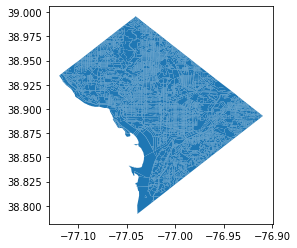

In [15]:
tabblock.plot()